Welcome to Week Six of our seminar on Applied Quantitative Methods in Finance. This week, we delve into the world of portfolio optimization, focusing on the trade-off between risk and reward. Our goal is to equip you with the tools and knowledge needed to construct, optimize and assess investment portfolios that align with specific financial objectives and risk tolerances.

Portfolio optimization is a critical aspect of modern finance, enabling investors to make informed decisions about asset allocation to maximize returns while minimizing risk. The concept, rooted in Harry Markowitz's Modern Portfolio Theory, involves selecting the proportions of various assets in a portfolio in such a way that the expected return is maximized for a given level of risk, or equivalently, the risk is minimized for a given level of expected return.

In this week's seminar, we introduce you to convex optimization techniques using the cvxpy package in Python. Convex optimization is a powerful mathematical approach that allows for the efficient solution of optimization problems with convex objectives and constraints, which are common in portfolio management scenarios. Through hands-on examples and practical exercises, you will learn to use cvxpy to solve optimization problems, such as minimizing portfolio variance, maximizing Sharpe ratios, and incorporating various constraints like budget and risk.

Get ready to explore the fascinating intersection of finance and optimization, and learn how to leverage advanced mathematical tools to research portfolio management strategies.

# Package Imports

In [2]:
import pandas as pd
import numpy as np

# to get asset price data
import yfinance as yf

# this is the library we use for optimization 
import cvxpy as cp

from plotnine import ggplot, aes, geom_line, geom_point, theme_minimal, geom_text, scale_x_date, theme, coord_fixed, labs
from mizani.formatters import date_format

# Review of Portfolio Optimization Techniques

In this section we will review the basic process of portfolio optimization.  We do this by first selecting data, then we dive into optimization with different objectives. Next, we create an efficient frontier, and ultimately we evaluate the portfolios using common metrics. 

## Data Retrieval

The key data we need are asset returns.  We can download them from both CRSP and Yahoo Finance, and in this section we opt for the Yahoo Finance to show some of the unique adaptations required. 

First we choose a few funds we want to download.

In [3]:
# define a list of asset tickers to retrieve data for
selected_tickers = [ "SPY",   # Large Cap
                     "AGG",   # Aggregate Bond Index
                     "QQQ",   # Large Cap Tech
                     "BWX",   # International Treasuries
                     "BIL",   # Cash
                   ]

Collect the data from 2000 onwards.

In [ ]:
yf_asset_data_ = yf.download(selected_tickers,'2000-1-1') 

In [5]:
# unstack data (remove one dimension and flatten the table) and remove NA values
asset_data_ = (yf_asset_data_
               .stack(level=1, future_stack=True)
               .rename_axis(['date', 'ticker'])
               .reset_index(level=1)
               .dropna()
              )

In [6]:
asset_data_.head()

,ticker,Adj Close,Close,High,Low,Open,Volume
date,,,,,,,
2000-01-03,QQQ,80.805206,94.7500,96.1875,90.750000,96.18750,36345200.0
2000-01-03,SPY,93.591156,145.4375,148.2500,143.875000,148.25000,8164300.0
2000-01-04,QQQ,75.261848,88.2500,93.5000,87.937500,92.00000,33786600.0
2000-01-04,SPY,89.931122,139.7500,144.0625,139.640625,143.53125,8089800.0
2000-01-05,QQQ,73.342987,86.0000,89.6250,84.250000,87.50000,42496600.0


Yahoo Finance data has some idiosyncacies that we need to clean up before progressing further.  And we also need to calculate returns as opposed to prices.  To ensure correct alignment of returns with potential investment decisions, we calculate open to open returns.  

In [7]:
asset_returns_ = pd.DataFrame()

#   clean data and calculate returns for each ticker
for ticker in selected_tickers:

    # do this for each ticker individually
    ticker_data = (asset_data_
                   .loc[asset_data_["ticker"] == ticker]
                   .copy()
                  )
    
    # nan-out nonpositive prices
    ticker_data.loc[ticker_data["Open"] <= 0, 'Open'] = np.nan
    ticker_data.loc[ticker_data["Close"] <= 0, "Close"] = np.nan
    ticker_data.loc[ticker_data["Adj Close"] <= 0, "Adj Close"] = np.nan
    
    # all infinity values are nans
    ticker_data.iloc[:, :] = np.nan_to_num(
        ticker_data.values, copy=True, nan=np.nan, posinf=np.nan, neginf=np.nan)
    # Price NA handling
    # fill close price with open price
    ticker_data['Close'] = ticker_data['Close'].fillna(ticker_data['Open'])
    
    # fill open price with close from day(s) before
    # repeat as long as it helps (up to 1 year)
    for shifter in range(252):
        orig_missing_opens = ticker_data['Open'].isnull().sum()
        ticker_data['Open'] = ticker_data['Open'].fillna(ticker_data['Close'].shift(
            shifter+1))
        new_missing_opens = ticker_data['Open'].isnull().sum()
        if orig_missing_opens == new_missing_opens:
            break
    # fill close price with same day's open after shifting
    ticker_data['Close'] = ticker_data['Close'].fillna(ticker_data['Open'])
    
    # calculate returns
    # compute log of ratio between adjclose and close
    log_adjustment_ratio = np.log(ticker_data['Adj Close'] / ticker_data['Close'])
    
    # forward fill adjustment ratio
    log_adjustment_ratio = log_adjustment_ratio.ffill()
    
    # non-market log returns (dividends, splits)
    non_market_lr = log_adjustment_ratio.diff().shift(-1)
    
    # full open-to-open returns
    open_to_open = np.log(ticker_data["Open"]).diff().shift(-1)
    ticker_data['open_to_open_return'] = np.exp(open_to_open + non_market_lr) - 1
    
    # drop unnecessary columns and last row (NA)
    ticker_data = ticker_data.drop(columns=["Adj Close", "Close","Open"]).dropna()
    
    asset_returns_ = pd.concat([asset_returns_, ticker_data])

For simpler processing, we now turn the long data frame into a wide data frame.  This gives us one column per asset, and the returns in each cell, with rows by day.

In [8]:
# turn the dataframe into wide format (dates as index, each asset as one column)
asset_returns_wide = (asset_returns_
                      .pivot( columns='ticker', values='open_to_open_return')
                      .dropna()
                     )

In [9]:
asset_returns_wide.head()

ticker,AGG,BIL,BWX,QQQ,SPY
date,,,,,
2007-10-11,1.610252e-03,2.179016e-04,-0.001727,-0.016545,-0.009367
2007-10-12,-1.205354e-03,-4.361811e-04,-0.001730,0.013422,0.005210
2007-10-15,2.312725e-03,9.301604e-07,-0.003081,-0.015296,-0.011902
2007-10-16,9.458981e-08,2.178324e-04,0.002125,0.015723,0.003691
2007-10-17,6.220869e-03,1.090258e-03,0.009637,-0.005409,-0.009872


## Generating Maximum Return Portfolios with Desired Risk Aversion

First we create an optimizer that finds the maximum of portfolio returns at a given level of risk aversion.  The following code creates the optimizer using cvxpy syntax that designed using convex optimization techniques, specifically targeting the balance between risk and return based on a given risk aversion parameter ($\gamma$). The function begins by setting the risk aversion parameter to the specified input value, which controls the trade-off between risk and return during the optimization process. It then solves the optimization problem, allowing up to 10,000 iterations to find the optimal weights for the portfolio assets.

Once the optimization is complete, the function calculates several key metrics for the portfolio. It determines the portfolio's variance, computes the annualized standard deviation by taking the square root of the variance, and calculates the annualized mean return. These values are used to derive the Sharpe ratio, which provides a measure of the portfolio's risk-adjusted return. The function also extracts the optimal weights for each asset in the portfolio from the optimization results. 

In [10]:
#  optimize a single portfolio, using risk aversion (gamma)
def optimize_portfolio(i_returns, i_gamma, i_max_exposure=0):

    ## calculate annualized geometric mean returns
    m_ret_ = (1 + i_returns).prod() ** (252 / i_returns.count()) - 1

    # calculate covariances and variances
    cov_ = i_returns.cov()*252

    # use portfolio values
    mu = np.array([m_ret_]).T
    Sigma = np.array(cov_)

    # define optimization problem
    w = cp.Variable(len(mu)) # weights
    gamma = cp.Parameter(nonneg=True) # desired risk exposure
    ret = mu.T@w # portfolio returns (matrix multiply returns times weights)
    risk = cp.quad_form(w, Sigma) # portfolio variance is the risk w@Sigma@w

    # constraint is that sum of weights needs to be 1
    _constraints = [
              cp.sum(w) == 1
          ]

    # constraint: maximum exposure needs to be less than maximum parameter
    if i_max_exposure > 0:
      _constraints += [cp.norm(w,1) <= i_max_exposure]
    else:
      _constraints += [w >= 0]

    # define the optimziation problem - maximize risk adjusted return (return minus risk) subject to constraints
    #    this is how we make the problem convex!
    prob = cp.Problem(cp.Maximize(ret - gamma*risk), _constraints)

    portfolio = pd.Series()
    
    gamma.value = i_gamma

    prob.solve(max_iter=10000 )
    portfolio['var'] = risk.value
    portfolio['ann_std'] = np.sqrt(portfolio['var'])
    portfolio['ann_mean_ret'] = ret.value[0]
    portfolio['SharpeRatio'] = portfolio['ann_mean_ret'] / (portfolio['ann_std'] )  # both of these have already been annualized earlier
    portfolio = pd.DataFrame(portfolio).T
    
    weights = pd.Series(w.value,index=i_returns.columns)
    portfolio['formatted_weights'] = "\n ".join([f"{ticker}: {weight:.2f}" for ticker, weight in weights.items()])

    return ( portfolio, weights )

Now, to use the function, we first select a set of assets to run the function on - here we choose the S\&P500 index and Aggregate Bonds. 

In [11]:
selected_asset_returns = asset_returns_wide.loc[:,["SPY", "AGG"]]

We set our risk aversion to 1.2.  Try running this with multiple levels of risk aversion, and see what happens! 

In [12]:
portfolio_, weights_ = optimize_portfolio(selected_asset_returns, i_gamma = 1.2)

Finally, we plot the portfolio on a risk/return canvas to understand its performance relative to benchmarks.

In [13]:
# calculate annual mean returns and sds for each of the assets
asset_locs = pd.DataFrame({
    'ann_mean_ret': (1 + selected_asset_returns).prod() ** (252 / selected_asset_returns.count()) - 1,
    'ann_std': selected_asset_returns.std() * np.sqrt(252)
})
asset_locs["ticker"] = asset_locs.index

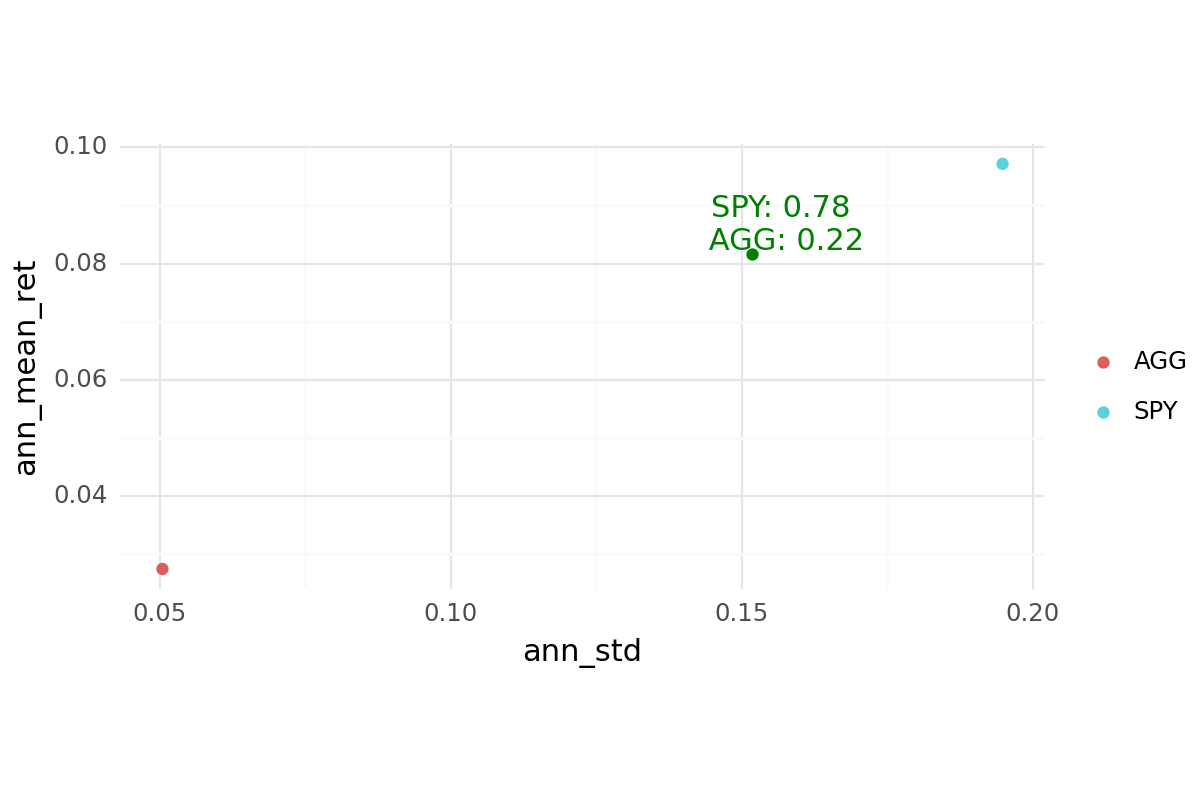

<Figure Size: (600 x 400)>

In [14]:
(
    ggplot()                
    + geom_point(asset_locs, aes(x='ann_std', y='ann_mean_ret', color = 'ticker'))
    + geom_point(portfolio_, aes(x='ann_std', y='ann_mean_ret'), color = 'green')
    + geom_text(portfolio_, aes(x='ann_std', y='ann_mean_ret', label='formatted_weights'), color = 'green', nudge_y=0.005, nudge_x=0.005)  
    + theme_minimal()
    + theme( figure_size=(6, 4) )
    + labs(color='')
    + coord_fixed()
)

## Generating Minium Risk Portfolios with Target Returns

We can use the exact same convex method to optimize with different objective functions.  If we for example want to minimize risk at a particular level of minimum return, we can do this by minimizing the portfolio's variance, effectively targeting the lowest possible risk for the specified return. 

In [36]:
#  optimize a single portfolio, setting minimum return
def optimize_target_return_portfolio(i_returns, i_min_annual_return, i_max_exposure=0):

    ## calculate annualized geometric mean returns
    m_ret_ = (1 + i_returns).prod() ** (252 / i_returns.count()) - 1

    # calculate covariances and variances
    cov_ = i_returns.cov()*252

    # use portfolio values
    mu = np.array([m_ret_]).T
    Sigma = np.array(cov_)

    # create weights variable
    w = cp.Variable(len(mu))

    # construct the objective function and constraints
    obj = cp.Minimize(w.T @ Sigma @ w)
    const = [
        cp.sum(w) == 1,  # weights sum to 1
        w >= 0,          # weights must be greater than zero
        w.T @ mu - i_min_annual_return >= 0 # returns must be larger than threshold
    ]
    
    # solve the problem
    prob = cp.Problem(obj, const )
    optimal_risk = prob.solve( max_iter=10000)

    portfolio = pd.Series()
    
    portfolio['var'] = optimal_risk
    portfolio['ann_std'] = np.sqrt(portfolio['var'])
    portfolio['ann_mean_ret'] = np.round(w.value.T@mu, 4)[0]
    portfolio['SharpeRatio'] = portfolio['ann_mean_ret'] / (portfolio['ann_std'] )  # both of these have already been annualized earlier
    portfolio = pd.DataFrame(portfolio).T
  
    weights = pd.Series(w.value,index=i_returns.columns)
    portfolio['formatted_weights'] = "\n ".join([f"{ticker}: {weight:.2f}" for ticker, weight in weights.items()])

    return ( portfolio , weights )

In [37]:
selected_asset_returns = asset_returns_wide.loc[:,["SPY", "AGG"]]

In [38]:
portfolio_, weights_ = optimize_target_return_portfolio(selected_asset_returns, i_min_annual_return = 0.09)
portfolio_

,var,ann_std,ann_mean_ret,SharpeRatio,formatted_weights
0,0.03112,0.176407,0.09,0.510183,SPY: 0.90\n AGG: 0.10


We show on a risk/return canvas where the generated portfolio is situated.   

In [39]:
# calculate annual mean returns and sds for each of the assets
asset_locs = pd.DataFrame({
    'ann_mean_ret': (1 + selected_asset_returns).prod() ** (252 / selected_asset_returns.count()) - 1,
    'ann_std': selected_asset_returns.std() * np.sqrt(252)
})
asset_locs["ticker"] = asset_locs.index

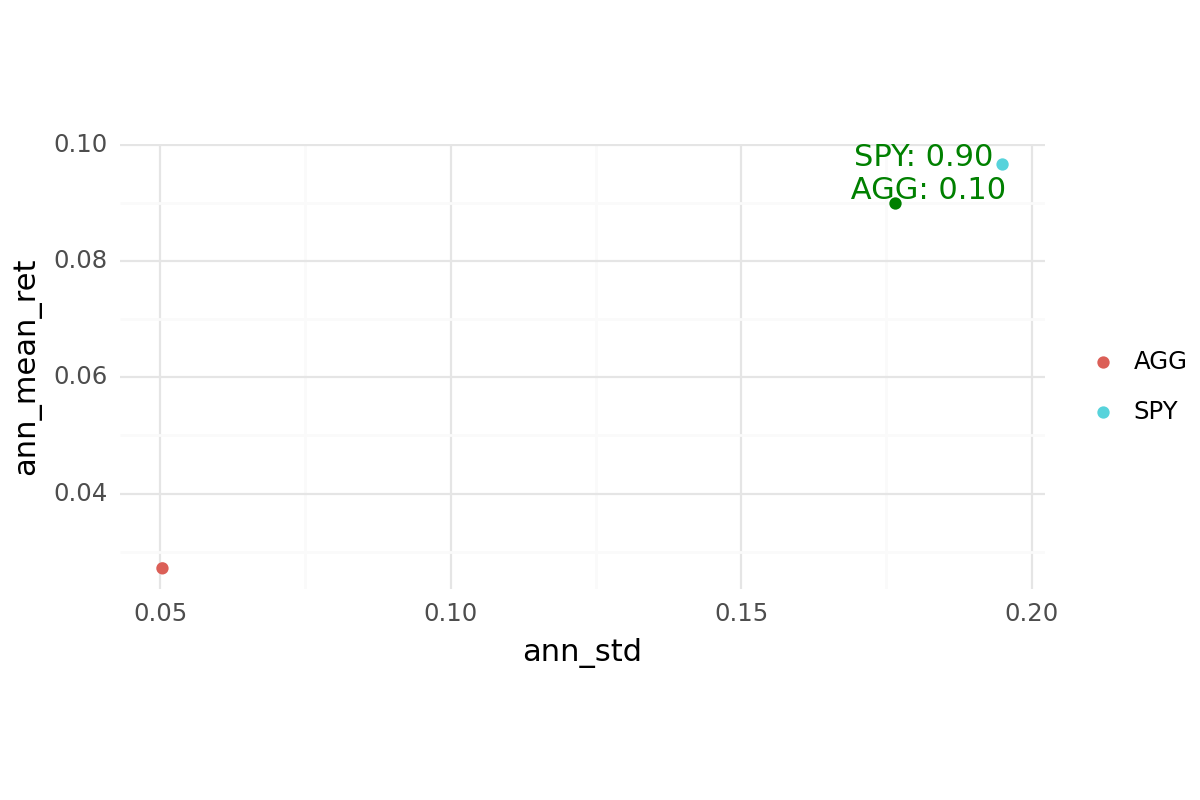

<Figure Size: (600 x 400)>

In [41]:
(
    ggplot()                
    + geom_point(asset_locs, aes(x='ann_std', y='ann_mean_ret', color = 'ticker'))
    + geom_point(portfolio_, aes(x='ann_std', y='ann_mean_ret'), color = 'green')
    + geom_text(portfolio_, aes(x='ann_std', y='ann_mean_ret', label='formatted_weights'), color = 'green', nudge_y=0.005, nudge_x=0.005)  
    + theme_minimal()
    + theme( figure_size=(6, 4) )
    + labs(color='')
    + coord_fixed()
)

## Calculating the Efficient Frontier

While we could calculate each portfolio combination separately on its own, it is useful to plot an efficient frontier as a reference point.  The efficient frontier is a concept in modern portfolio theory that represents the set of optimal portfolios offering the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. 

These portfolios are considered "efficient" because they provide the best possible return for their level of risk, or equivalently, the lowest risk for their level of return, given the asset selection. The efficient frontier is typically visualized as a curved line on a graph where the x-axis represents risk (usually measured by standard deviation) and the y-axis represents expected return. Portfolios lying on the efficient frontier are deemed superior to those lying below it, which are considered sub-optimal. 

We calculate the efficient frontier by looping over multiple levels of risk aversion in this function. 

In [60]:
# get series of values of the efficient frontier using a convex optimizer
#  parameter i_max_exposure determines max amount of leverage e.g. 1.5 = gross exposure < 150%
#  parameter i_returns is a pandas dataframe of return values
def calculate_efficient_frontier(i_returns, i_max_exposure=0):

    ## calculate annualized geometric mean returns
    m_ret_ = (1 + i_returns).prod() ** (252 / i_returns.count()) - 1

    # calculate covariances and variances
    cov_ = i_returns.cov()*252

    # use portfolio values
    mu = np.array([m_ret_]).T
    Sigma = np.array(cov_)

    # define optimization problem
    w = cp.Variable(len(mu)) # weights
    gamma = cp.Parameter(nonneg=True) # desired risk exposure
    ret = mu.T@w # portfolio returns (returns times weights)
    risk = cp.quad_form(w, Sigma) # portfolio variance is the risk w@Sigma@w

    # constraint is that sum of weights needs to be 1
    _constraints = [
              cp.sum(w) == 1
          ]

    # maximum exposure needs to be less than maximum
    if i_max_exposure > 0:
      _constraints += [cp.norm(w,1) <= i_max_exposure]
    else:
      _constraints += [w >= 0]

    # define the optimziation problem - maximize risk adjusted return subject to constraints
    prob = cp.Problem(cp.Maximize(ret - gamma*risk), _constraints)

    # function to run the optimizer once for each value of gamma (risk appetite)
    def _calc_weights_risk_ret_optimizer (row):
      gamma.value = row["gamma"]
      try: # sometimes solver runs into issues, the try block ensures this doesn't block processing
        prob.solve(max_iter=10000 )
        row['var'] = risk.value
        row['sigma'] = np.sqrt(row['var'])
        row['ret'] = ret.value[0]
        row['SharpeRatio'] = row['ret'] / (row['sigma'] )  # both of these have already been annualized earlier
        # add weight information
        row = pd.concat([row,pd.Series(w.value,index=i_returns.columns).round(decimals=4)])  # add weights for each optimum
        return row
      except Exception as e:
        return None
    
    # initialize results dataframe
    df_ef_vals_ = pd.DataFrame(np.logspace(-2, 2, num=100), columns=["gamma"]) # define risk space
    df_ef_vals_ = df_ef_vals_.apply(_calc_weights_risk_ret_optimizer, axis=1) # calculate frontier for each gamma
    df_ef_vals_ = df_ef_vals_.dropna() # sometimes the solver runs into problems - ignore those rows!
    
    return ( df_ef_vals_ )

We select the asset set to calculate the frontier, and execute our function. 

In [61]:
selected_asset_returns = asset_returns_wide.loc[:,["SPY", "AGG"]]

In [62]:
frontier = calculate_efficient_frontier(selected_asset_returns)

This calculates a list of portfolios at different levels of $\gamma$.

In [63]:
frontier.head()

,gamma,var,sigma,ret,SharpeRatio,SPY,AGG
0,0.010000,0.038014,0.194971,0.096619,0.495557,1.0,0.0
1,0.010975,0.038014,0.194971,0.096619,0.495557,1.0,0.0
2,0.012045,0.038014,0.194971,0.096619,0.495557,1.0,0.0
3,0.013219,0.038014,0.194971,0.096619,0.495557,1.0,0.0
4,0.014508,0.038014,0.194971,0.096619,0.495557,1.0,0.0


We visualize the efficient frontier on the same risk/return canvas as before.

In [64]:
# calculate annual mean returns and sds for each of the assets
asset_locs = pd.DataFrame({
    'ann_mean_ret': (1 + selected_asset_returns).prod() ** (252 / selected_asset_returns.count()) - 1,
    'ann_std': selected_asset_returns.std() * np.sqrt(252)
})
asset_locs["ticker"] = asset_locs.index

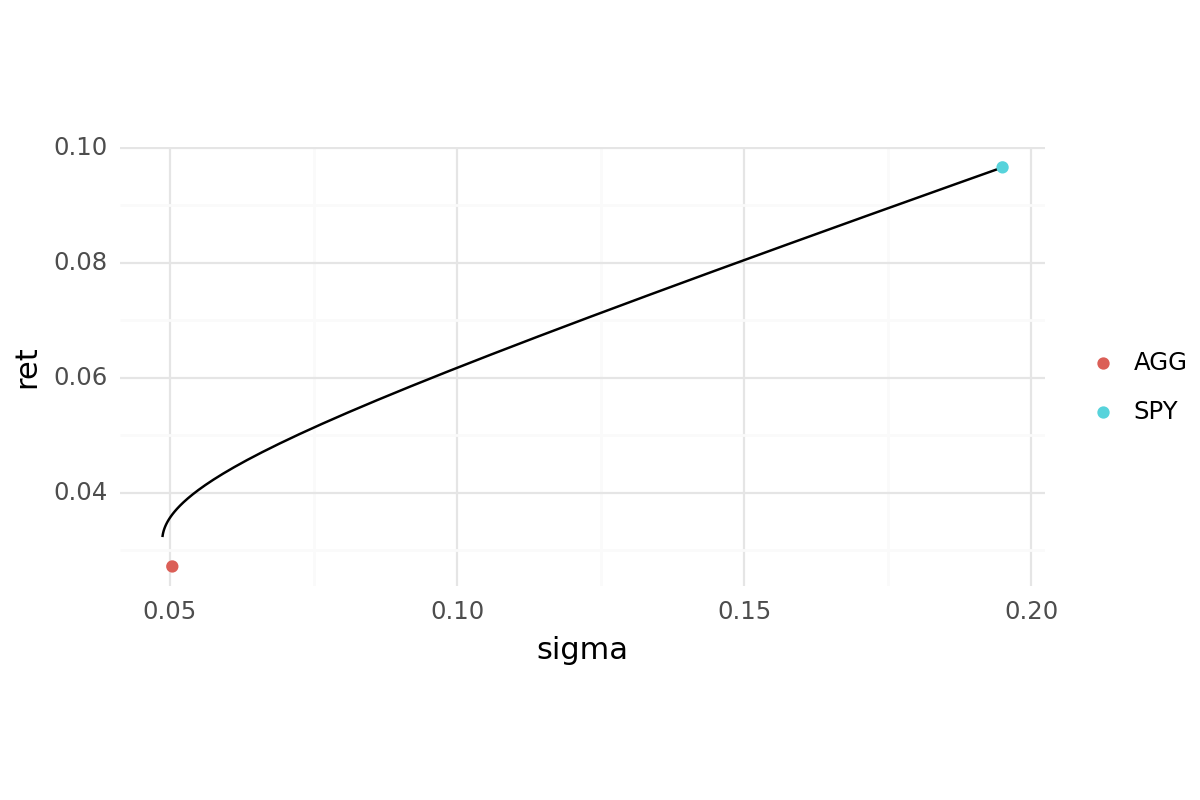

<Figure Size: (600 x 400)>

In [65]:
# the efficient frontier of the selected assets and dots for each asset individually
(
    ggplot(data = frontier)         
    + geom_line(frontier, aes(x="sigma", y="ret"))           
    + geom_point(asset_locs, aes(x='ann_std', y='ann_mean_ret', color = 'ticker'))
    + theme_minimal()
    + theme( figure_size=(6, 4) )
    + labs(color='')
    + coord_fixed()
)

## Visually Combining the Efficient Frontier and Portfolios

Now that we know how to plot the efficient frontier, we can put any new portfolio we generate and optimize in context of it.  Here we plot the last optimized portfolio on the same grid as the efficient frontier. 

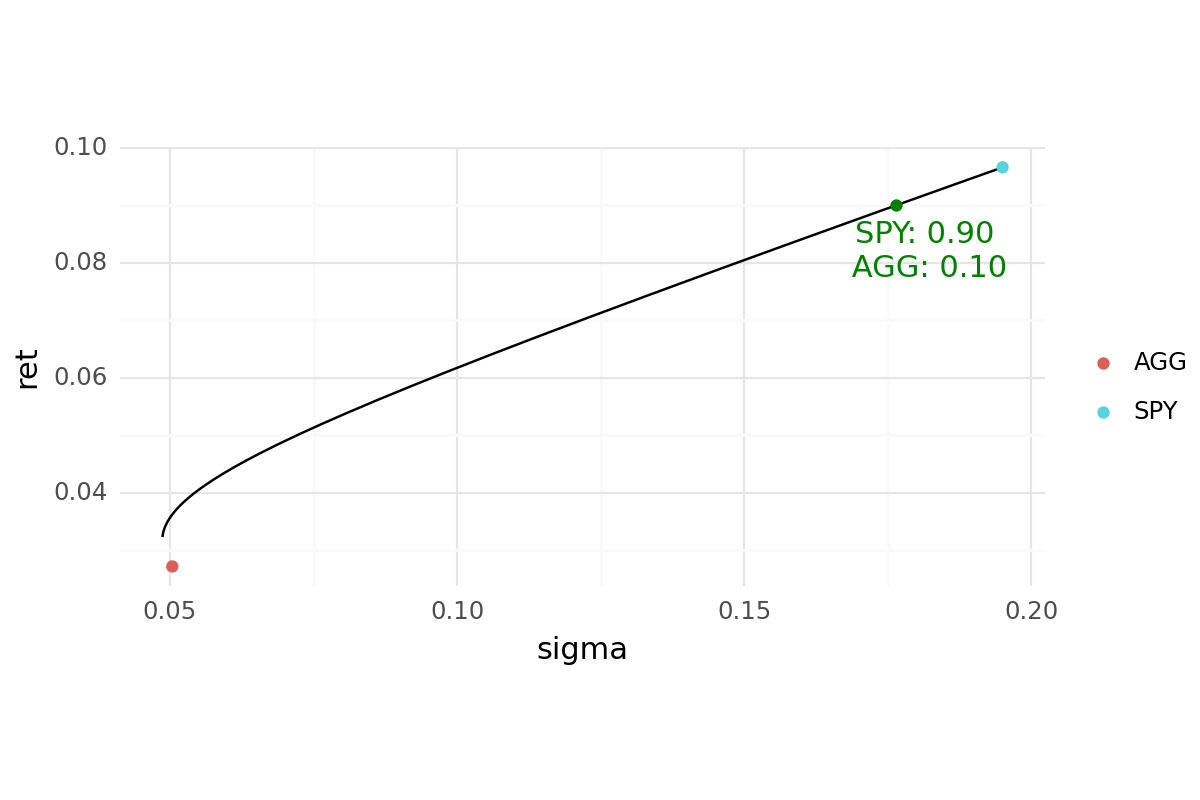

<Figure Size: (600 x 400)>

In [71]:
# The efficient frontier of the selected assets and dots for each asset individually
(
    ggplot()         
    + geom_line(frontier, aes(x="sigma", y="ret"))           
    + geom_point(asset_locs, aes(x='ann_std', y='ann_mean_ret', color = 'ticker'))
    + geom_point(portfolio_, aes(x='ann_std', y='ann_mean_ret'), color = 'green')
    + geom_text(portfolio_, aes(x='ann_std', y='ann_mean_ret', label='formatted_weights'), color = 'green', nudge_y=-0.008, nudge_x=0.005)  
    + theme_minimal()
    + theme( figure_size=(6, 4) )
    + labs(color='')
    + coord_fixed()
)

## Calculating Portfolio Metrics

To understand how well a portfolio performs, we define a few metrics, specifically the Sharpe ratio, Sortino ratio and Maximum Drawdown. 

The **Sharpe Ratio** is a widely-used metric in finance that measures the risk-adjusted return of an investment or portfolio. It is calculated by subtracting the risk-free rate from the portfolio's return and then dividing this excess return by the portfolio's standard deviation, which represents its total risk. The ratio provides a single value that reflects how much excess return is being earned for each unit of risk taken. A higher Sharpe Ratio indicates a more favorable risk-adjusted return, implying that the investment is efficiently balancing risk and reward. Investors use the Sharpe Ratio to compare different investments or portfolios, helping them to identify those that offer the best potential returns for a given level of risk.

The **Sortino Ratio** is a variation of the Sharpe Ratio that focuses on downside risk, providing a more targeted measure of risk-adjusted return. Unlike the Sharpe Ratio, which considers total volatility, the Sortino Ratio only penalizes for negative deviations from a specified target or the risk-free rate, effectively ignoring upside volatility. It is calculated by subtracting the target return from the portfolio's return and dividing this excess return by the downside deviation, which measures the variability of negative returns. The Sortino Ratio offers a clearer picture of how well an investment or portfolio performs relative to downside risk, making it a valuable tool for investors who are particularly concerned about minimizing losses while achieving their return objectives.

**Maximum Drawdown** is a risk metric that quantifies the largest single drop from peak to trough in the value of an investment or portfolio over a specific period. It is calculated as the maximum observed loss from a peak to a subsequent trough before a new peak is attained. MDD is expressed as a percentage of the peak value and provides insight into the potential downside risk of an investment. By highlighting the worst-case scenario, maximum drawdown helps investors understand the extent of potential losses and the risk of experiencing significant declines in value. This metric is particularly useful for assessing the resilience of an investment strategy during market downturns.


In [15]:
# Definition of core functions

def sharpe_ratio(returns, N=252, rf=0.01):
    """
    Function to calculate the Sharpe ratio
    :param returns: A pandas Series representing the returns.
    :param N: Number of trading periods per year.
    :param rf: The risk free rate.
    :return: The Sharpe ratio as a float.
    """
    mean = returns.mean() * N - rf
    sigma = returns.std() * np.sqrt(N)
    return ( mean / (sigma + 1E-8) )

def sortino_ratio(returns, N=252, rf=0.01, target=0):
    """
    Function to calculate the Sortino ratio.
    :param returns: A pandas Series representing the returns.
    :param N: Number of trading periods per year.
    :param rf: The risk free rate.
    :param target: The minimum acceptable return, often set to 0 or the risk free rate.
    :return: The Sortino ratio as a float.
    """
    # Annualized excess return over the target
    excess_returns = returns - target
    mean_excess_return = excess_returns.mean() * N - rf

    # Downside deviation (only considering negative excess returns)
    negative_excess_returns = excess_returns[excess_returns < 0]
    downside_deviation = np.sqrt((negative_excess_returns**2).mean()) * np.sqrt(N)

    # Calculate Sortino ratio, avoid division by zero
    if downside_deviation == 0:
        return np.inf
    return mean_excess_return / downside_deviation

def maximum_drawdown(returns):
    """
    Calculate the maximum drawdown for a pandas Series of returns.
    :param returns: A pandas Series representing the returns.
    :return: The maximum drawdown as a float.
    """
    # Calculate cumulative returns
    cumulative_returns = (1 + returns).cumprod()
    # Calculate the running maximum
    running_max = cumulative_returns.cummax()
    # Calculate the drawdown
    drawdown = (cumulative_returns - running_max) / running_max
    # Calculate the maximum drawdown
    max_drawdown = drawdown.min()
    return max_drawdown

In order to calculate these metrics, we need to calculate weighted portfolio returns by multiplying the optimzed weights with the individual fund returns. 

In [19]:
# calculate weighted portfolio returns
weighted_portfolio_returns = selected_asset_returns @ weights_
weighted_portfolio_returns.name = "custom_portfolio"

Now we enrich the portfolio metrics DataFrame with these additional metrics.

In [20]:
portfolio_.assign(
            cum_ret=( (1 + weighted_portfolio_returns).cumprod() - 1 ) .iloc[-1],
            mean_ret = weighted_portfolio_returns.mean(),
            max_drawdown = maximum_drawdown(weighted_portfolio_returns),
            SharpeRatio	= sharpe_ratio(weighted_portfolio_returns),
            SortinoRatio = sortino_ratio(weighted_portfolio_returns)
                  )

,var,ann_std,ann_mean_ret,SharpeRatio,formatted_weights,cum_ret,mean_ret,max_drawdown,SortinoRatio
0,0.023032,0.151765,0.081637,0.548321,SPY: 0.78\n AGG: 0.22,2.889464,0.00037,-0.445371,0.510332


We want to compare the metrics to a benchmark, so we need to calculate the same metrics for the benchmark returns series. 

In [39]:
benchmark_returns = selected_asset_returns["SPY"]

pd.DataFrame(dict(
        var= benchmark_returns.var() * 252,
        ann_std = np.sqrt( benchmark_returns.var() * 252 ),
        ann_mean_ret = (1 + benchmark_returns).prod() ** (252 / benchmark_returns.count()) - 1 ,
        cum_ret=( (1 + benchmark_returns).cumprod() - 1 ) .iloc[-1], 
        mean_ret = benchmark_returns.mean(),
        max_drawdown = maximum_drawdown(benchmark_returns),
        SharpeRatio	= sharpe_ratio(benchmark_returns),
        SortinoRatio = sortino_ratio(benchmark_returns)
    ), index=[0])

,var,ann_std,ann_mean_ret,cum_ret,mean_ret,max_drawdown,SharpeRatio,SortinoRatio
0,0.037954,0.194818,0.097124,3.673595,0.000443,-0.552346,0.522321,0.487606


The custom portfolio exhibits a lower annualized standard deviation (0.15) compared to SPY (0.19), indicating that it is less volatile. This aligns with its composition, which includes a mix of SPY (78%) and AGG (22%), thus incorporating bonds to reduce overall portfolio risk. The annualized mean return for the custom portfolio is 0.08, which is lower than SPY's 0.10, reflecting a more conservative return expectation due to the bond component. The Sharpe Ratio for the custom portfolio is 0.55, slightly higher than SPY's 0.52, suggesting that the custom portfolio has a marginally better risk-adjusted return. The Sortino Ratio, which measures downside risk-adjusted returns, is also higher for the custom portfolio (0.51) compared to SPY (0.49), further indicating effective downside risk management.

The SPY, as expected for an equity-focused investment, shows higher volatility with an annualized standard deviation of 0.19. Its annualized mean return is 0.10, higher than that of the custom portfolio, indicating better overall performance in terms of returns. However, this comes at the cost of higher risk, as evidenced by the higher maximum drawdown of -0.55 compared to the custom portfolio's -0.45. Despite the higher volatility and drawdown, SPY's Sharpe Ratio of 0.52 and Sortino Ratio of 0.49 indicate strong risk-adjusted performance.

Overall, while the SPY offers higher returns with greater volatility, the custom portfolio strikes a balance between risk and return, achieving better risk-adjusted metrics, making it a viable option for investors looking for stability with reasonable returns.

## Backtesting Portfolio Strategies

Backtesting is an essential practice in portfolio management, serving as a critical tool for evaluating the performance of investment strategies over historical periods. By applying a trading strategy to historical data, backtesting allows researchers and portfolio managers to simulate how a portfolio would have performed in the past, providing valuable insights into its potential future performance. This retrospective analysis helps in identifying strengths and weaknesses of the strategy, revealing periods of strong performance as well as times when the strategy may have faltered. 

While imperfect, because of the extrapolation of historical performance, we can assess the robustness and consistency of strategies, understand the impact of different market conditions, and refine their approach to enhance returns and manage risks more effectively. Backtesting is instrumental in identifying time-varying performance, highlighting how strategies might behave under varying economic cycles and market environments, enabling more informed strategic refinements.

We combine the calculated portfolio returns, and the returns of the underlying assets to be able to compare and contrast the backtest profiles. 

In [431]:
combined_returns = selected_asset_returns.join(weighted_portfolio_returns)

### Cumulative Returns

Next, we calculate cumulative returns, which are used in backtesting because they provide a clear and comprehensive view of the total investment performance over a specified period. 

By calculating the cumulative return, investors can see the compounded effect of gains and losses over time, which is crucial for understanding the long-term viability and success of a strategy. This metric helps to visualize the growth of an initial investment, taking into account the reinvestment of returns, and offers a straightforward comparison between different strategies or assets over the same period. Additionally, cumulative returns highlight the overall trajectory of a portfolio, making it easier to identify periods of consistent performance, volatility, and drawdowns. Using cumulative returns in backtesting thus enables investors to assess not only the final outcome of a strategy but also its journey, providing deeper insights into its behavior and resilience through various market conditions.

In [432]:
combined_cumulative_returns = ( ( (1 + combined_returns).cumprod() - 1 )
                               .reset_index()
                               .melt(id_vars=['date'], var_name='Portfolio', value_name='Cumulative Return')
                                )

Notice that we melt the dataframe, meaning we make it a 'long' pivot, because this format enables us to plot it easily with plotnine. 

In [433]:
combined_cumulative_returns

,date,Portfolio,Cumulative Return
0,2007-10-11,SPY,-0.009368
1,2007-10-12,SPY,-0.004205
2,2007-10-15,SPY,-0.016058
3,2007-10-16,SPY,-0.012426
4,2007-10-17,SPY,-0.022176
...,...,...,...
12502,2024-04-29,custom_portfolio,3.120156
12503,2024-04-30,custom_portfolio,3.068737
12504,2024-05-01,custom_portfolio,3.089215
12505,2024-05-02,custom_portfolio,3.144864


Finally we create the cumulative returns line plot. 

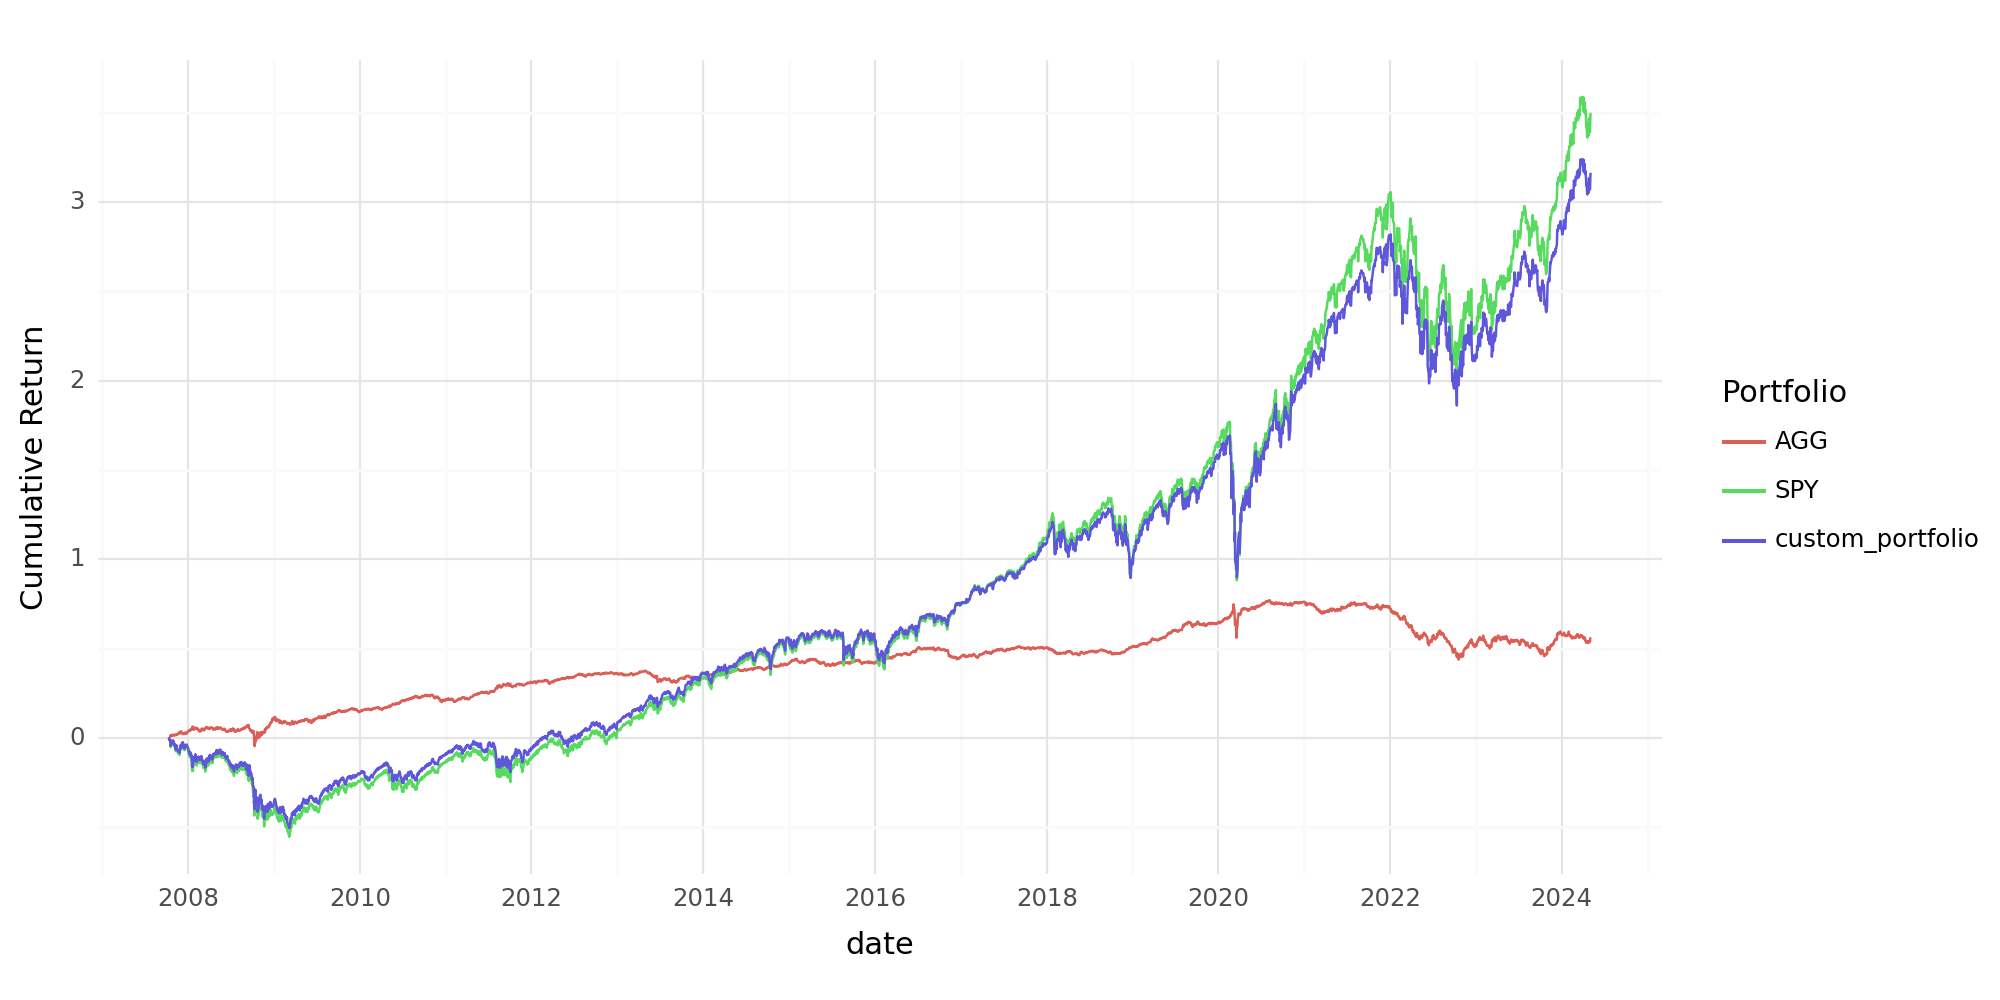

<Figure Size: (1000 x 500)>

In [435]:
# Plot cumulative returns over time
(
    ggplot(data = combined_cumulative_returns) 
    + aes(x="date", y="Cumulative Return", color="Portfolio")         
    + geom_line()           
    + theme_minimal()
    + scale_x_date(labels=date_format('%Y'))
    + theme( figure_size=(10, 5))
)

### Rolling Performance Metrics

Another great way to analyze portfolio returns is by examining rolling metrics. This approach is particularly valuable because portfolio performance can vary significantly over time, and rarely does a single portfolio consistently outperform benchmarks throughout different periods. By calculating rolling metrics, researchers can gain insights into how performance evolves and identify periods of relative strength and weakness.

In this analysis, we focus on calculating a rolling Sharpe ratio, which provides a dynamic view of the portfolio's risk-adjusted returns. To add statistical depth, we also calculate and display the confidence intervals for the rolling Sharpe ratio. This enhanced view allows us to understand the variability and reliability of the Sharpe ratio over time. By considering the confidence intervals, we can assess the statistical significance of changes in the Sharpe ratio, offering a richer and more nuanced analysis of portfolio performance. This method acknowledges the strong time variation in performance and leverages a rolling view to provide a comprehensive understanding of how the portfolio's risk and return characteristics evolve.

In [359]:
# calculate Sharpe ratio confidence intervals
def sharpe_ratio_confidence_interval(returns, rf=0.01, confidence_level=1.96):
    """
    Function to calculate the Sharpe ratio and its confidence intervals.
    
    :param returns: A pandas Series representing the returns.
    :param rf: The risk-free rate, default is 0.01.
    :param confidence_level: The z-score for the desired confidence level, default is 1.96 for a 95% confidence interval.
    :return: A pandas Series containing the Sharpe ratio, the lower bound, and the upper bound of the confidence interval.
    """
    if len(returns) < 2:
        return pd.Series([None, None, None])
    sr = sharpe_ratio(returns=returns, rf=rf)
    N = len(returns)
    se = np.sqrt((1 / (N - 1)) * (1 + 0.5 * sr**2))
    ci_lower = sr - confidence_level * se
    ci_upper = sr + confidence_level * se
    return pd.Series([sr, ci_lower, ci_upper])


Because we calculate rolling metrics, we need to select a window.  In this case we choose three trading years. 

In [424]:
window_size = 252 *3

Here we calculate the rolling Sharpe Ratios and their confidence intervals for each column in the combined returns.

In [425]:
portfolios_with_cis = pd.DataFrame()
for series in combined_returns.columns: 
    # Apply rolling Sharpe ratio and CI calculation using the rolling split function
    ci_df = pd.DataFrame([sharpe_ratio_confidence_interval(df_) for df_ in combined_returns[series].rolling(window_size)])
    ci_df = ci_df.iloc[window_size:,] #cut off first rows that had shorter calculation windows
    ci_df.columns = ['SharpeRatio','CILower','CIUpper']
    ci_df.index = combined_returns.index[window_size:]
    ci_df['series'] = series
    portfolios_with_cis = pd.concat([portfolios_with_cis, ci_df]) 
portfolios_with_cis['date'] = portfolios_with_cis.index

And finally we plot this on a time series graph. 

/home/erik/jupyterlab/env/lib/python3.11/site-packages/mizani/transforms.py:687: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


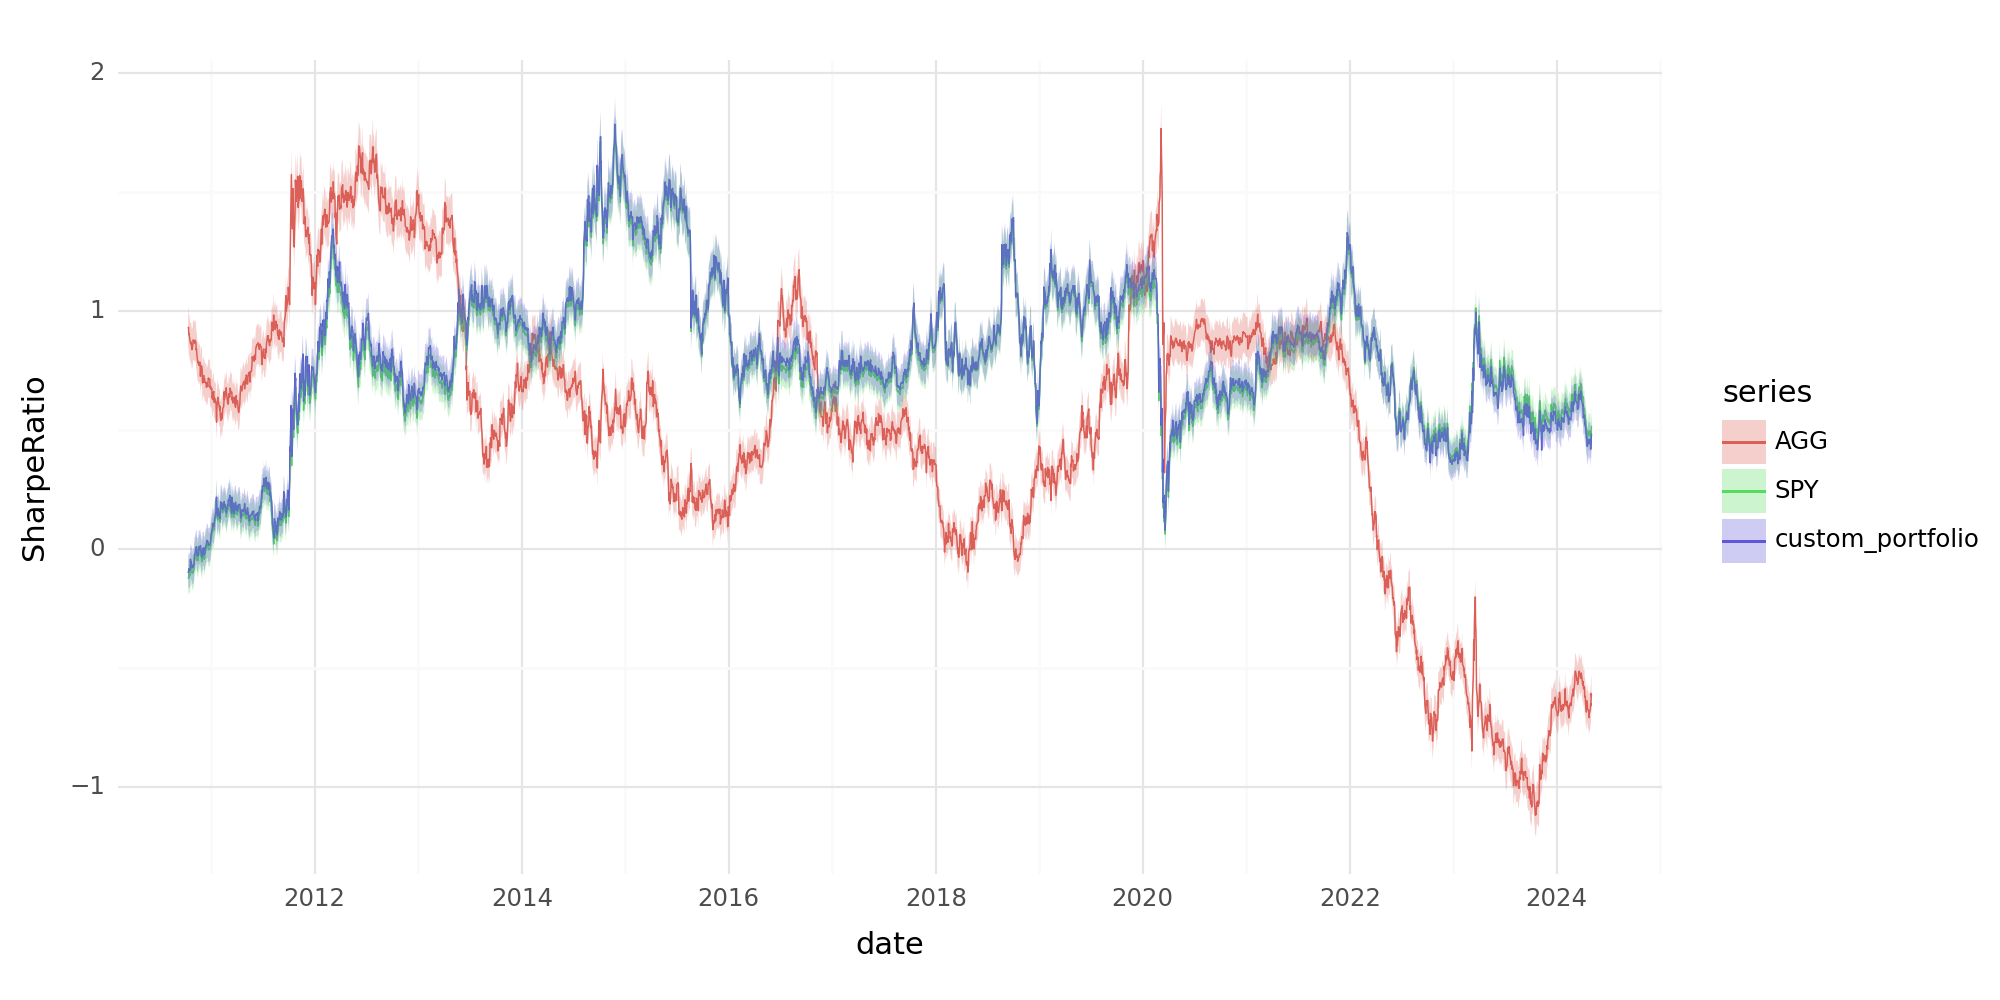

<Figure Size: (1000 x 500)>

In [426]:
# plotting a rolling Sharpe ratio graph for all assets including shaded confidence intervals
(
    ggplot(portfolios_with_cis, aes(x='date', y='SharpeRatio', color='series')) 
    + geom_line(size = 0.3) 
    + geom_ribbon(aes(ymin='CILower', ymax='CIUpper', fill='series'), size = 0, alpha=0.3) 
    + theme_minimal()
    + scale_x_date(labels=date_format('%Y'))
    + theme( figure_size=(10, 5))
)

The graph presents the rolling three-year Sharpe ratios for three different portfolios: AGG (a bond ETF), SPY (an S&P 500 ETF), and a custom portfolio. The Sharpe ratio, which measures the risk-adjusted return, is plotted over time from 2010 to 2024, providing insights into how each portfolio's performance has evolved relative to its risk.

The Sharpe ratio for AGG shows significant variation over the observed period. Initially, AGG's Sharpe ratio climbs steadily, peaking around 2012 with values well above 1, indicating strong risk-adjusted returns during this period. However, starting from 2014, there is a noticeable decline, with the ratio falling below 1 and even dipping into negative territory in recent years. This suggests that the bond market, as represented by AGG, faced increasing challenges, possibly due to rising interest rates and changing economic conditions. The consistent decline in AGG's Sharpe ratio post-2020 highlights the struggles within the bond market, reflecting lower risk-adjusted returns and increased volatility.

The SPY's Sharpe ratio exhibits a different pattern, characterized by relatively higher stability and resilience. Throughout most of the period, SPY maintains a Sharpe ratio around or above 1, indicating strong risk-adjusted performance. The ratio fluctuates, with notable peaks around 2013 and 2018, aligning with periods of robust equity market performance. Despite some dips, such as during the 2020 COVID-19 market turmoil, SPY quickly recovers, demonstrating the resilience of the equity market. The relatively stable and higher Sharpe ratio of SPY suggests that the equity market has consistently offered favorable risk-adjusted returns, making it a reliable investment for growth-oriented portfolios.

The custom portfolio's Sharpe ratio closely mirrors that of SPY, indicating that the custom portfolio's performance and risk characteristics are very similar to those of the S&P 500. This indistinguishability suggests that the custom portfolio is heavily weighted towards equities similar to those in the S&P 500, or perhaps it is designed to track the S&P 500 closely. The alignment in their Sharpe ratios implies that the custom portfolio has achieved similar risk-adjusted returns as SPY, benefitting from the equity market's performance while being subject to the same market volatilities and trends.

In summary, the rolling three-year Sharpe ratio graph underscores the robust performance of equity-focused investments (SPY and the custom portfolio) compared to bonds (AGG). The custom portfolio's similarity to SPY suggests a strategy closely aligned with the S&P 500, capitalizing on the equity market's favorable risk-adjusted returns over the past decade.

# Assignment

Design a hypothesis of how the inclusion of a crypto-asset impacts portfolio performance.  
- Take a benchmark of SPY and AGG and hypothesize on how the efficient frontier changes with the addition of such assets?
- How do you expect the key metrics change?
- Carry out an empirical analysis and determine if you find evidence for your hypothesis.
  - Calculate and interpret the relevant fit metrics.
  - Plot two efficient frontiers on one graph, one with and one without consideration for crypto assets.
  - Add an example of an optimized portfolio to this graph. 

(For your empirical analysis, the choice of crypto-asset is yours, but give you a head start, you can use daily ETH returns available on my GitHub site at https://github.com/emekelburg/DUEPHDFINMETHODS2024/raw/main/ETH_historical_returns.parquet.  You load these into a python DataFrame as shown below.  Note, you need to merge these returns together with other asset returns before commencing your analysis.)

Hint: Consider that crypto assets do not observe trading days, like traditional stocks.  Justify your choice of method you use to combine the returns.


In [ ]:
# reading ETH returns from GitHub
ETH_returns = pd.read_parquet('https://github.com/emekelburg/DUEPHDFINMETHODS2024/raw/main/ETH_historical_returns.parquet')